In [ ]:
pip install openpyxl

In [1]:
from time import time
import multiprocessing as mp
from numpy.random import default_rng
import pandas as pd
import sys,codecs
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import collections
import random
import warnings
warnings.filterwarnings("ignore")

## Some functions

In [2]:
# CMLE-gradient
def gardient_initial_lj(nn, p, Wc, para, Yj):
    rho_j = para[0]
    sigma2_j = para[1]
    
    S = np.eye(nn)-rho_j*Wc
    S_inverse = np.linalg.inv(S)
    G = Wc@S_inverse
    Ep = S@Yj
    
    g1 = -np.trace(G)+np.dot((Wc@Yj).T,Ep)/sigma2_j
    g2 = -nn/(2*sigma2_j)+(Ep.T@Ep)/(2*(sigma2_j**2))
    
    return np.array([g1,g2])

In [3]:
# FMLE-gradient
def gardient_lj(nn, p, the0, Z_e, Yj,Wc):

    rhoj = the0[0]
    betaj = the0[1]
    tauj2 = the0[2]

    S = np.eye(nn)-rhoj*Wc
    S_inverse = np.linalg.inv(S)
    G = Wc@S_inverse
    Ep = S@Yj-Z_e*betaj
    
    g1 = -np.trace(G)+np.dot((Wc@Yj).T,Ep)/tauj2
    g2 = (Z_e.T@Ep)/tauj2
    g3 = -nn/(2*tauj2)+(Ep.T@Ep)/(2*tauj2**2)
    
    return np.array([g1,g2,g3])

In [4]:
# CMLE-hessian
def hessian_initial_lj(nn, p, Wc, para, Yj):
    
    rho_j = para[0]
    sigma2_j = para[1]
    
    S = np.eye(nn)-rho_j*Wc
    S_inverse = np.linalg.inv(S)
    G = np.dot(Wc,S_inverse)
    WWc = np.dot(Wc.T,Wc)
    WS = np.dot(Wc.T,S)
    SS = np.dot(S.T,S)
    
    
    h11 = -np.trace(G@G)-np.dot(Yj.T@WWc,Yj)/sigma2_j
    h12 = h21 = -np.dot(np.dot(Yj.T,WS),Yj)/(sigma2_j**2)
    h22 = nn/(2*sigma2_j**2)-np.dot(Yj.T@SS,Yj)/(sigma2_j**3)
    
    return np.array([[h11,h12],[h21,h22]])

In [5]:
# FMLE-hessian
def hessian_lj(nn, p, the0, Z_e, Yj,Wc):
    
    rhoj = the0[0]
    betaj = the0[1]
    tauj2 = the0[2]
    
    S = np.eye(nn)-rhoj*Wc
    S_inverse = np.linalg.inv(S)
    G = np.dot(Wc,S_inverse)
    WY = Wc@Yj
    Ep = S@Yj-Z_e*betaj
    
    h11 = -np.trace(G@G) - WY.T@WY/tauj2
    h12 = h21 = -Z_e.T@WY/tauj2
    h13 = h31 = -WY.T@Ep/tauj2**2
    h22 = -Z_e.T@Z_e/tauj2
    h23 = h32 = -Z_e.T@Ep/(2*tauj2**2)
    h33 = nn/(2*tauj2**2)-Ep.T@Ep/(tauj2**3)
    
    return np.array([[h11,h12,h13],[h21,h22,h23],[h31,h32,h33]])

In [6]:
# Newton - iteration CMLE
def newton_sea_initial(nn, p, pa0,Wc, Yj, max_iter = 50, eps = 1e-4):

    pa_new = pa0
    for t in range(max_iter):
        pa_pre = pa_new
        gradient = gardient_initial_lj(nn, p,Wc, pa_pre, Yj)/nn
        hessian =  hessian_initial_lj(nn, p,Wc, pa_pre, Yj)/nn 
        diff = np.linalg.inv(hessian+0.001*np.eye(2)).dot(gradient)
        pa_new = pa_pre - diff 
        if np.linalg.norm(diff) < eps:
            break
            
    return pa_new,t+1

In [7]:
# Newton - iteration FMLE
def newton_sea(nn, p, theta0, Z_e, Yj, Wc,max_iter = 50, eps = 1e-4):

    theta_new = theta0
    for t in range(max_iter):
        theta_pre = theta_new
        gradient = gardient_lj(nn, p, theta_pre, Z_e, Yj,Wc)/nn 
        #print(gradient)
        hessian =  hessian_lj(nn, p, theta_pre, Z_e, Yj,Wc)/nn 
        diff = np.linalg.inv(hessian+0.0001*np.eye(3)).dot(gradient)
        theta_new = theta_pre - diff

        if np.linalg.norm(diff) < eps:
            break
            
    return theta_new,t+1

In [8]:
# CMLE
def optimize_initial(nn, p, Wc, Yc):
    
    para = np.zeros((2,p))
    ite = np.zeros(p)
    for j in range(p):
        par = np.array([0,np.var(Yc[:,j])])
        res = newton_sea_initial(nn, p, par, Wc, Yc[:,j])
        para[:,j] = res[0]
        ite[j] = res[1]
        print('initial:',j, para[0,j])
    
    return para[0,:],para[1,:],ite

In [9]:
# FMLE
def optimize(nn, p, Z_e, Y,Wc):
    
    theta = np.zeros((3,p))
    itee = np.zeros(p)
    theta0 = np.array([0,0,0.0001])
    for j in range(p):
        res = newton_sea(nn, p, theta0, Z_e, Y[:,j],Wc)
        theta[:,j] = res[0]
        itee[j] = res[1]
        print('update:',j, theta[0,j])
    
    return theta[0,:],theta[1,:], theta[2,:], itee

In [10]:
# Factor estimation
def Z_est_new(n, n1, p,d, Y, rho_e, We, Wb, Yb, rho_hb):
    
    Eb = Yb - (Wb@Yb)@np.diag(rho_hb) 
    Sigma = Eb.T@Eb/n1
  
    U, G, V = np.linalg.svd(Sigma)
    M = U[:,:d]@np.diag(G[:d])**0.5
    
    E = Y - (We@Y)@np.diag(rho_e)
    Z_e = E@M/p
    
    return Z_e, M

# Real Data

In [11]:
# Adjacent matrix
W = pd.read_excel('01matrix.xlsx',engine='openpyxl')
W.index = W.iloc[:,0]

In [12]:
# economic indicators
Y = pd.read_excel('Citydata.xlsx',engine='openpyxl')

In [13]:
Y.index = Y.iloc[:,0]
Y

,城市,地区生产总值_当年价格-全市（亿元）,地区生产总值增长率-全市(%),第二产业占地区生产总值的比重-全市,第三产业占地区生产总值的比重-全市,户籍人口-全市(万人),城镇单位从业人员期末人数-全市(人),城镇登记失业人员数-全市(人),第二产业从业人员比重-全市,第三产业从业人员比重-全市,...,年末金融机构人民币各项存款余额（万元）全市,住户存款余额（万元）全市,人工或天然气居民家庭用量_市辖区,液化石油气供气总量（吨）市辖区,规模以上工业企业主要财务指标_利润总额（万元）市辖区,城镇职工基本养老保险参保人数（人）全市,普通本专科在校学生数（人）全市,年末总户数（万户）全市,死亡人口（人）全市,商品房待售面积（万平方米）全市
城市,,,,,,,,,,,,,,,,,,,,,
北京,北京,35371,6.1,16.16,83.52,1397,7912978,93500,15.57,84.38,...,1643000000,373100000,145888,434286,17102542,16516233,585971,554,49152,2490
天津,天津,14104,4.8,35.23,63.46,1108,2693543,260900,38.02,61.89,...,307000000,126400000,73687,52996,12120302,6955700,572152,406,75752,658
石家庄,石家庄,5810,6.7,31.53,60.74,1052,1069381,54539,26.21,73.69,...,149600000,76300235,6098,44380,1907517,2681067,533070,311,32109,77
唐山,唐山,6890,7.3,52.44,39.85,756,779209,39008,40.82,57.43,...,101400000,67027713,17438,18130,2496025,2450555,146262,231,62278,126
秦皇岛,秦皇岛,1612,6.7,32.89,54.31,301,275565,17742,31.67,68.20,...,36219883,25918648,6919,2128,686310,950665,94673,118,16357,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
石嘴山,石嘴山,511,7.0,48.73,45.70,75,71788,23074,34.63,64.88,...,6450399,4826754,8817,41,336128,298982,10651,29,4743,48
吴忠,吴忠,580,7.1,44.34,43.59,143,99952,2673,28.31,69.54,...,7292592,4708183,5324,1595,141402,255627,5308,49,10774,119
固原,固原,323,6.5,19.39,62.92,147,72332,3426,15.26,84.60,...,4968269,2894125,2082,1930,66164,96744,7868,44,12421,85


In [14]:
city_name_W = list((W.columns)[1:])
city_name_Y = set(Y.loc[:,'城市'])
diff = list(set(city_name_W).difference(city_name_Y))
for i in diff:
    city_name_W.remove(i)
len(city_name_W)

278

In [15]:
WW = W.loc[city_name_W,city_name_W]
WW

,北京,天津,石家庄,唐山,秦皇岛,邯郸,邢台,保定,张家口,承德,...,庆阳,定西,陇南,西宁,银川,石嘴山,吴忠,固原,乌鲁木齐,克拉玛依
a,,,,,,,,,,,,,,,,,,,,,
北京,0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
天津,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
石家庄,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
唐山,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
秦皇岛,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
石嘴山,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
吴忠,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
固原,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [16]:
YY = (Y.loc[city_name_W,:]).iloc[:,1:]
YY

,地区生产总值_当年价格-全市（亿元）,地区生产总值增长率-全市(%),第二产业占地区生产总值的比重-全市,第三产业占地区生产总值的比重-全市,户籍人口-全市(万人),城镇单位从业人员期末人数-全市(人),城镇登记失业人员数-全市(人),第二产业从业人员比重-全市,第三产业从业人员比重-全市,第一产业从业人员-全市(人),...,年末金融机构人民币各项存款余额（万元）全市,住户存款余额（万元）全市,人工或天然气居民家庭用量_市辖区,液化石油气供气总量（吨）市辖区,规模以上工业企业主要财务指标_利润总额（万元）市辖区,城镇职工基本养老保险参保人数（人）全市,普通本专科在校学生数（人）全市,年末总户数（万户）全市,死亡人口（人）全市,商品房待售面积（万平方米）全市
城市,,,,,,,,,,,,,,,,,,,,,
北京,35371,6.1,16.16,83.52,1397,7912978,93500,15.57,84.38,3585,...,1643000000,373100000,145888,434286,17102542,16516233,585971,554,49152,2490
天津,14104,4.8,35.23,63.46,1108,2693543,260900,38.02,61.89,2518,...,307000000,126400000,73687,52996,12120302,6955700,572152,406,75752,658
石家庄,5810,6.7,31.53,60.74,1052,1069381,54539,26.21,73.69,1051,...,149600000,76300235,6098,44380,1907517,2681067,533070,311,32109,77
唐山,6890,7.3,52.44,39.85,756,779209,39008,40.82,57.43,13586,...,101400000,67027713,17438,18130,2496025,2450555,146262,231,62278,126
秦皇岛,1612,6.7,32.89,54.31,301,275565,17742,31.67,68.20,360,...,36219883,25918648,6919,2128,686310,950665,94673,118,16357,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
石嘴山,511,7.0,48.73,45.70,75,71788,23074,34.63,64.88,354,...,6450399,4826754,8817,41,336128,298982,10651,29,4743,48
吴忠,580,7.1,44.34,43.59,143,99952,2673,28.31,69.54,2143,...,7292592,4708183,5324,1595,141402,255627,5308,49,10774,119
固原,323,6.5,19.39,62.92,147,72332,3426,15.26,84.60,104,...,4968269,2894125,2082,1930,66164,96744,7868,44,12421,85


In [17]:
# random partition method 
from random import sample
n,p = YY.shape
n1 = int(0.1*n)
random.seed(345)
name = sample(city_name_W, n)
WW = WW.loc[name,name]
YY = YY.loc[name,:]

In [18]:
# divide sample
WWn = WW.iloc[:n1,:n1]
WWo = WW.iloc[n1:,n1:]
Yn = YY.iloc[:n1,:]
Yo = YY.iloc[n1:,:]
A = np.array(WW)
Ao = np.array(WWo)
A1 = np.array(WWn)
Y = np.array(YY)
Yo = np.array(Yo)
Y1 = np.array(Yn)
p = Y.shape[1]
n0 = Ao.shape[0];

In [19]:
# Weight matrix
W = A/np.sum(A,1).reshape(n,1) 
W1 = A1/np.sum(A1,1).reshape(n1,1) 
Wo = Ao/np.sum(Ao,1).reshape(n0,1) 
W1[np.isnan(W1)] = 0
Wo[np.isnan(Wo)] = 0

In [20]:
# standardized Y
Y_log = np.log(abs(Y))
Y_log[np.where(Y_log==float('-Inf'))] = 0
Y_stand = (Y_log - np.mean(Y_log,0))/np.std(Y_log)

Y1_log = np.log(abs(Y1))
Y1_log[np.where(Y1_log==float('-Inf'))] = 0
Y1_stand = (Y1_log - np.mean(Y1_log,0))/np.std(Y1_log)

Yo_log = np.log(abs(Yo))
Yo_log[np.where(Yo_log==float('-Inf'))] = 0
Yo_stand = (Yo_log - np.mean(Yo_log,0))/np.std(Yo_log)

In [ ]:
# Check Y 
for j in range(p):
    plt.hist((Y_stand[:,j]))
    plt.show()

In [21]:
# CMLE
rho_hi, sigma2_hi, ite_hi = optimize_initial(n0, p, Wo, Yo_stand)

initial: 0 0.46236819312964456
initial: 1 0.4813096249872884
initial: 2 0.4416817704430621
initial: 3 0.0944080096379763
initial: 4 0.4099834167741401
initial: 5 0.3186023131930024
initial: 6 0.10717412628003466
initial: 7 0.458489076349763
initial: 8 0.4230132596783151
initial: 9 0.3568373419033519
initial: 10 0.0839403900231266
initial: 11 0.4183344438556845
initial: 12 0.10831791095207813
initial: 13 0.2504976617189795
initial: 14 0.22368700632087254
initial: 15 0.3481471644053733
initial: 16 0.4056809896879016
initial: 17 0.42180495242384863
initial: 18 0.3939242794763195
initial: 19 0.3144157931942524
initial: 20 0.22500959815622643
initial: 21 0.33505893909664325
initial: 22 0.3651598319794544
initial: 23 0.40955767216268996
initial: 24 0.09811212965585925
initial: 25 0.2272280541859296
initial: 26 0.40572114136098636
initial: 27 0.2541672367313178
initial: 28 0.2986685653443975
initial: 29 0.4413583261015328
initial: 30 0.16633969238391907
initial: 31 0.11798796600102501
initial

In [22]:
spatial_effect_cmle = pd.DataFrame({'indicator':YY.columns, 'effect_cmle': rho_hi})
spatial_effect_cmle.sort_values(by='effect_cmle', ascending=True, inplace=True)
spatial_effect_cmle

,indicator,effect_cmle
37,第三产业_文化体育和娱乐业（人）全市,0.065275
10,第二产业_电力热力燃气及水生产和供应业从业人员-全市(人),0.083940
3,第三产业占地区生产总值的比重-全市,0.094408
24,全年公共汽电车客运总量_万人次_市辖区,0.098112
6,城镇登记失业人员数-全市(人),0.107174
12,第三产业_交通运输仓储和邮政业（人）全市,0.108318
31,第三产业_信息传输计算机服务和软件业（人）全市,0.117988
34,第三产业_水利环境和公共设施管理业（人）全市,0.121218
46,普通本专科在校学生数（人）全市,0.137855
30,第三产业从业人员（人）全市,0.166340


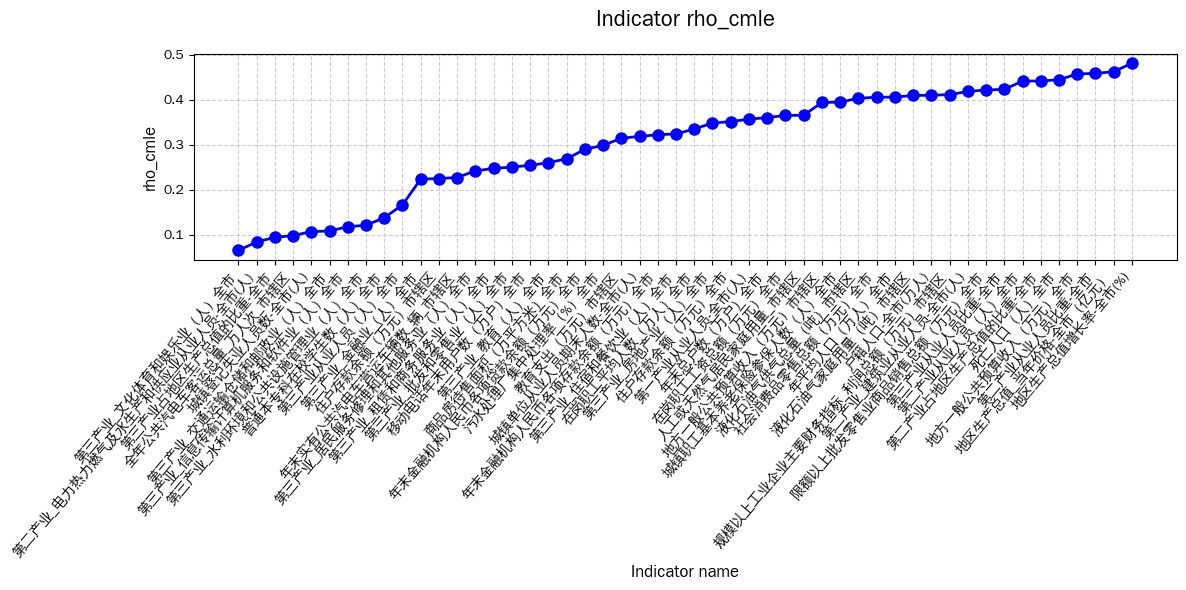

In [23]:
# Visualization CMLE

plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  
plt.rcParams['axes.unicode_minus'] = False  

plt.figure(figsize=(12, 6))
plt.plot(spatial_effect_cmle["indicator"], spatial_effect_cmle["effect_cmle"], marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

plt.title("Indicator rho_cmle", fontsize=16, pad=20)
plt.xlabel("Indicator name", fontsize=12)
plt.ylabel("rho_cmle", fontsize=12)

plt.xticks(rotation=50, ha='right', fontsize=10)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [24]:
spatial = pd.read_excel('Indicator group.xlsx',engine='openpyxl')
spatial.rename(columns={'指标名称': 'indicator'}, inplace=True)

In [25]:
spatial_total = pd.merge(spatial_effect_cmle, spatial, on='indicator', how='inner')
spatial_total.columns = ['indicator', 'effect_cmle', 'Tertiary', 'Population', 'Fiscal', 'Public Services']
#spatial_total

(14, 1)
(16, 1)
(13, 1)
(7, 1)


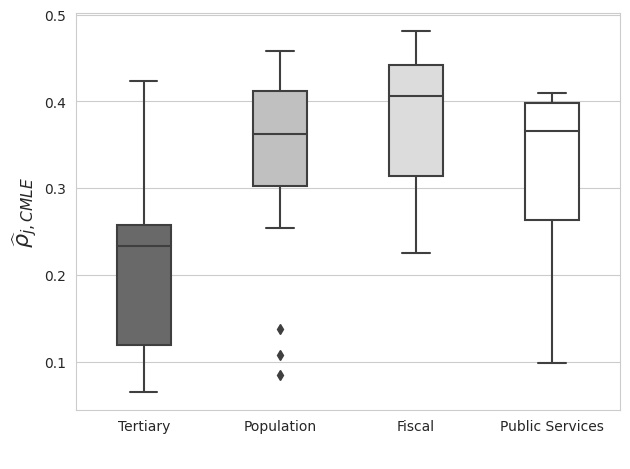

In [26]:
# Visualization
categories = ['Tertiary', 'Population', 'Fiscal', 'Public Services']
long_df = pd.DataFrame()

for cat in categories:
    temp = spatial_total[spatial_total[cat] == 1][['effect_cmle']].copy()
    print(temp.shape)
    temp['category'] = cat
    long_df = pd.concat([long_df, temp], axis=0)
    
sns.set_style("whitegrid") # 设置背景样式
ax_Block = sns.boxplot(
    x='category', y='effect_cmle',
    data=long_df,
    width=0.4,
    palette= ['dimgrey','silver','gainsboro','white'],
    )
plt.xlabel(' ',fontsize=16)
plt.ylabel(r'$\widehat{\rho}_{j,CMLE}$', fontsize=16)

plt.tight_layout()
plt.savefig('rhocmle_4c1.pdf',bbox_inches = 'tight')
plt.show()

In [27]:
# sd-cmle
rho_cmle_se = np.zeros(p)
for j in range(p):
    S = np.eye(n0)-rho_hi[j]*Wo
    S_inverse = np.linalg.inv(S)
    G = np.dot(Wo,S_inverse)

    h11 = np.trace((G+G.T)@G)/n0
    h12 = h21 = np.trace(G)/(n0*sigma2_hi[j])
    h22 = 1/(2*sigma2_hi[j]**4)

    Sigma_2 = np.array([[h11,h12],[h21,h22]])
    Covariance = np.linalg.inv(Sigma_2)
    rho_cmle_se[j] = np.sqrt((Covariance/n0)[0,0])  

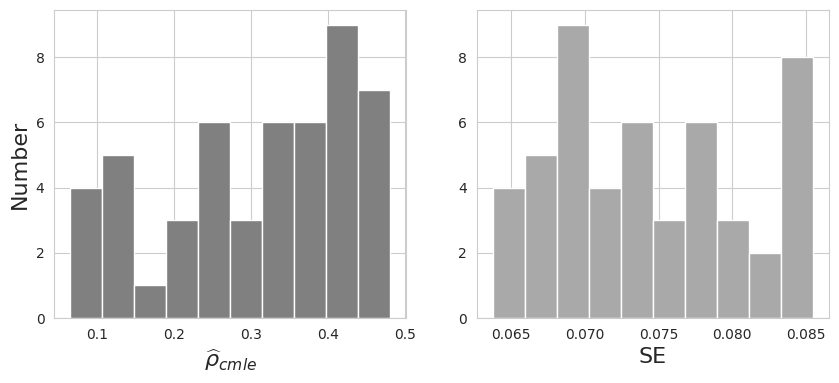

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist(rho_hi, color = 'gray')
plt.xlabel(r'$\widehat{\rho}_{cmle}$', fontsize=16)
plt.ylabel('Number', fontsize=16)


plt.subplot(122)
plt.hist(rho_cmle_se, color = 'darkgray')
plt.xlabel('SE', fontsize=16)

plt.savefig('rhocmle_se.pdf',bbox_inches = 'tight')
plt.show()

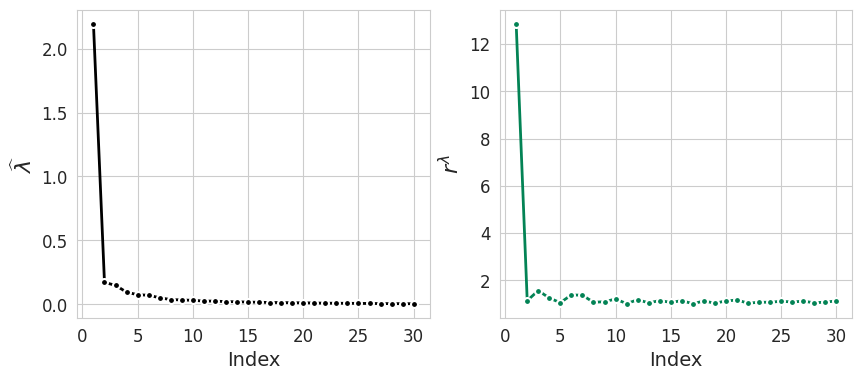

In [29]:
# Factor dimension 
E = Y_stand - (W@Y_stand)@np.diag(rho_hi)
Sigma = E.T@E/n0
e_vals,e_vecs = np.linalg.eig(Sigma)
e_vals = sorted(e_vals, reverse=True)

# eigenvalue ration
ratio = []
for i in range(p-1):
    ra = e_vals[i]/e_vals[i+1]
    ratio.append(ra)

# Visualization
color1 = "#038355" 
color2 = "#ffc34e" 
font = {'family' : 'Times New Roman',
        'size'   : 12}
plt.rc('font', **font)
sns.set_style("whitegrid") 
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.lineplot(x=np.array(range(30))+1,y=e_vals[:30], color='black', linewidth=2.0, marker="o", markersize=5, markeredgecolor="white", markeredgewidth=1.5)
plt.xlabel('Index', fontsize=14)
plt.ylabel(r'$\widehat{\lambda}$', fontsize=16)


plt.subplot(122)
sns.lineplot(x=np.array(range(30))+1,y=ratio[:30], color=color1, linewidth=2.0, marker="o", markersize=5, markeredgecolor="white", markeredgewidth=1.5)
plt.xlabel('Index', fontsize=14)
plt.ylabel(r'$r^{\lambda}$', fontsize=16)
plt.savefig('eigen.pdf',bbox_inches ='tight')
plt.show()

In [30]:
# CMLE -- for factor estimation
rho_hb, sigma2_hb, ite_hb = optimize_initial(n1, p, W1, Y1_stand)

initial: 0 0.25422020731406303
initial: 1 0.28691543661509994
initial: 2 0.1862105499020235
initial: 3 -0.01921091608129164
initial: 4 0.2660707835468431
initial: 5 0.18394663040474388
initial: 6 0.2555085370342673
initial: 7 0.11505872065090852
initial: 8 -0.004408096516136343
initial: 9 0.1835106368790899
initial: 10 0.10865397368479458
initial: 11 0.1662101845594666
initial: 12 0.09999780763985451
initial: 13 0.05303090603543321
initial: 14 -0.06702375576797871
initial: 15 -0.0041436989644026145
initial: 16 0.25650984821409156
initial: 17 0.1598521301484318
initial: 18 0.22790657014013155
initial: 19 0.14255622746424504
initial: 20 0.09815535629507516
initial: 21 0.21373974744400476
initial: 22 0.1966807525645489
initial: 23 0.26906384774036934
initial: 24 0.12389074058788158
initial: 25 0.1068583845334305
initial: 26 0.2663491819118143
initial: 27 0.20368435096309584
initial: 28 0.10385979373270714
initial: 29 0.28460320113147985
initial: 30 0.049410403041230476
initial: 31 0.15175

In [31]:
# Factor estimation
Z_h,M_h = Z_est_new(n, n1, p, 1, Yo_stand, rho_hi, Wo, W1, Y1_stand, rho_hb)
Z_h = Z_h.reshape((n0))
Z_h.shape

(251,)

In [32]:
# FMLE
rho_hf, beta_hf, tau2_hf, ite_hf = optimize(n0, p, Z_h, Yo_stand, Wo)

update: 0 0.45774043376641577
update: 1 0.48095866916507757
update: 2 0.4452307773465518
update: 3 0.18307642007736047
update: 4 0.44760423999116505
update: 5 0.3270338203416217
update: 6 0.16836254242990692
update: 7 0.41669632403373164
update: 8 0.3937196809309797
update: 9 0.40953856668846167
update: 10 0.26617384564194907
update: 11 0.45254583947184296
update: 12 0.16122664229300587
update: 13 0.2788928807204743
update: 14 0.2527470398352164
update: 15 0.3761540457784159
update: 16 0.40881224318610215
update: 17 0.4391926224296051
update: 18 0.39709107569656943
update: 19 0.3122173092766797
update: 20 0.2700729441721591
update: 21 0.3336297625458684
update: 22 0.34044499432887604
update: 23 0.40238395221492335
update: 24 0.20890062453136535
update: 25 0.2752794821651621
update: 26 0.44240909616606433
update: 27 0.2834251513831215
update: 28 0.2927273530006084
update: 29 0.41168309553861726
update: 30 0.21595623233516856
update: 31 0.16682280684112374
update: 32 0.3533730432412163
u

In [33]:
spatial_effect_fmle = pd.DataFrame({'indicator':YY.columns, 'effect_fmle': rho_hf})
spatial_effect_fmle.sort_values(by='effect_fmle', ascending=True, inplace=True)
spatial_effect_fmle

,indicator,effect_fmle
37,第三产业_文化体育和娱乐业（人）全市,0.158041
12,第三产业_交通运输仓储和邮政业（人）全市,0.161227
31,第三产业_信息传输计算机服务和软件业（人）全市,0.166823
6,城镇登记失业人员数-全市(人),0.168363
3,第三产业占地区生产总值的比重-全市,0.183076
34,第三产业_水利环境和公共设施管理业（人）全市,0.191527
46,普通本专科在校学生数（人）全市,0.192944
24,全年公共汽电车客运总量_万人次_市辖区,0.208901
30,第三产业从业人员（人）全市,0.215956
35,第三产业_居民服务修理和其他服务业（人）全市,0.234587


In [34]:
# sd-fmle
rho_fmle_se = np.zeros(p)
sig_z2 = np.var(Z_h)
for j in range(p):
    S = np.eye(n0)-rho_hf[j]*Wo
    S_inverse = np.linalg.inv(S)
    G = np.dot(Wo,S_inverse)


    C11 = np.trace((G+G.T)@G)/n0 + np.trace(G.T@G)*sig_z2*beta_hf[j]**2/(n0*tau2_hf[j]**2)
    C12 = C21 = sig_z2*beta_hf[j]*np.trace(G)/(n0*tau2_hf[j]**2)
    C13 = C31 = np.trace(G)/(n0*tau2_hf[j]**2)
    C22 = sig_z2/tau2_hf[j]**2
    C32 = C23 = 0
    C33 = 1/(2*tau2_hf[j]**4)
    Sigma_2 = np.array([[C11,C12,C13], [C21,C22,C23], [C31,C32,C33]])
    Covariance = np.linalg.inv(Sigma_2)
    rho_fmle_se[j] = np.sqrt((Covariance/n0)[0,0])

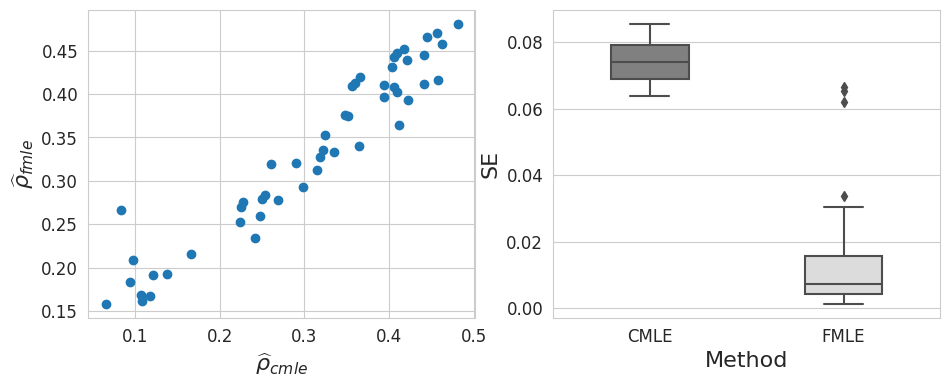

In [35]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.scatter(rho_hi,rho_hf)
plt.xlabel(r'$\widehat{\rho}_{cmle}$', fontsize=16)
plt.ylabel(r'$\widehat{\rho}_{fmle}$', fontsize=16)

plt.subplot(122)

rho_se = np.array([rho_cmle_se.T,rho_fmle_se.T])
plabel = ['CMLE']*p+['FMLE']*p
dfp_Block = pd.DataFrame({'se':(rho_se).flatten(),'p':plabel})
ax_Block = sns.boxplot(
    x='p',
    y='se', 
    data=dfp_Block,
    width=0.4,
    palette= ['grey','gainsboro'],

)
plt.xlabel('Method',fontsize=16)
plt.ylabel('SE', fontsize=16)

plt.savefig('rhofmle_com.pdf',bbox_inches = 'tight')
plt.show()